# 0. Initialization & Dependencies

In [67]:
import json
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.tree import DecisionTreeRegressor

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)

# 1. Data Loading & Initial Preparation

In [68]:
# load Data
df = pd.read_csv("../data/processed/Southern_Vietnam_Weather_processed.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['datetime']).copy()
df = df.sort_values(['name', 'datetime'])

# 2. Target Creation

In [69]:
# Create Target Column
# Predict Tempmax_C of Tomorrow
df['target'] = df.groupby('name')['tempmax_C'].shift(-1)
df = df.dropna(subset=['target']).reset_index(drop=True)
TARGET = 'target'

# 3. Temporal Train/Validation/Test Split (Gap-Aware)

In [70]:
#    Split Train / Val / Test with GAP
#    - Test: 12 tháng cuối (tính theo EFFECTIVE_MAX = max_date - 1 ngày)
#    - Val : 6 tháng liền trước Test, chừa GAP 30 ngày
#    - Train: phần còn lại, chừa GAP 30 ngày trước Val

max_date = df['datetime'].max()                                # ví dụ 2025-09-01
EFFECTIVE_MAX = max_date - pd.Timedelta(days=1)                # 2025-08-31 (do shift -1)
TEST_END   = EFFECTIVE_MAX
TEST_START = TEST_END - pd.DateOffset(years=1) + pd.Timedelta(days=1)   # 12 tháng

GAP_DAYS = 30

VAL_END   = TEST_START - pd.Timedelta(days=GAP_DAYS) - pd.Timedelta(days=1)
VAL_START = VAL_END   - pd.DateOffset(months=6) + pd.Timedelta(days=1)  # 6 tháng

TRAIN_START = df['datetime'].min()
TRAIN_END   = VAL_START - pd.Timedelta(days=GAP_DAYS) - pd.Timedelta(days=1)

# Masks
train_mask = (df['datetime'] >= TRAIN_START) & (df['datetime'] <= TRAIN_END)
val_mask   = (df['datetime'] >= VAL_START)   & (df['datetime'] <= VAL_END)
test_mask  = (df['datetime'] >= TEST_START)  & (df['datetime'] <= TEST_END)

# Kiểm tra không giao nhau
assert not (train_mask & val_mask).any()
assert not (train_mask & test_mask).any()
assert not (val_mask   & test_mask).any()

# (Tuỳ chọn) In thông tin khoảng thời gian
print("TRAIN:", df.loc[train_mask, 'datetime'].min().date(), "->", df.loc[train_mask, 'datetime'].max().date())
print("VAL  :", df.loc[val_mask,   'datetime'].min().date(), "->", df.loc[val_mask,   'datetime'].max().date())
print("TEST :", df.loc[test_mask,  'datetime'].min().date(), "->", df.loc[test_mask,  'datetime'].max().date())


# Tạo X/y cho từng tập
X_all = df.drop(columns=[TARGET])
y_all = df[TARGET]

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]


TRAIN: 2015-01-01 -> 2024-01-01
VAL  : 2024-02-01 -> 2024-07-31
TEST : 2024-08-31 -> 2025-08-30


# 4. Baseline Preprocessing — “Raw” Design Matrix

In [71]:
# Bỏ datetime khỏi num_cols 
cat_cols = ['name']
num_cols = [c for c in X_train.columns if c not in cat_cols and c not in ['datetime', 'tempmax_C']]

all_provinces = sorted(df['name'].dropna().unique())
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop= None, handle_unknown='ignore', sparse_output=False, categories=[all_provinces]), cat_cols),
        ('num', 'passthrough', num_cols), 
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

raw_pipeline = Pipeline([('preprocess', preprocess)])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test  = raw_pipeline.transform(X_test)

feature_names = raw_pipeline.named_steps['preprocess'].get_feature_names_out()
X_raw_train_df = pd.DataFrame(X_raw_train, columns=feature_names, index=X_train.index)
X_raw_val_df = pd.DataFrame(X_raw_val, columns=feature_names, index=X_val.index)
X_raw_test_df  = pd.DataFrame(X_raw_test,  columns=feature_names, index=X_test.index)

## Save ouput

In [72]:
out_dir = Path('../data') / "splits" 
out_dir.mkdir(parents=True, exist_ok=True)

raw_train_out = pd.concat(
    [X_raw_train_df.reset_index(drop=True),
     y_train.rename(TARGET).reset_index(drop=True),
     X_train[['datetime', 'name']].reset_index(drop=True)],  # thêm datetime
    axis=1
)
raw_train_out.to_csv(out_dir / 'raw_train.csv', index=False)

raw_val_out = pd.concat(
    [X_raw_val_df.reset_index(drop=True),
     y_val.rename(TARGET).reset_index(drop=True),
     X_val[['datetime', 'name']].reset_index(drop=True)],  # thêm datetime
    axis=1
)
raw_val_out.to_csv(out_dir / 'raw_val.csv', index=False)

raw_test_out = pd.concat(
    [X_raw_test_df.reset_index(drop=True),
    y_test.rename(TARGET).reset_index(drop=True),
    X_test[['datetime', 'name']].reset_index(drop=True)],
    axis=1
)
raw_test_out.to_csv(out_dir / 'raw_test.csv', index=False)

pd.Series(feature_names).to_json(out_dir / 'orig_feature_columns.json')

# 5. Model-Based Feature Selection on Raw Data(Decision Tree)

In [73]:
# Using Decision Tree to select Features
dt_feature_selection_pipeline  = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeRegressor(random_state=42))
])

# Fit DT lên tập Train
dt_feature_selection_pipeline.fit(X_train, y_train)

feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances[:10])

temp_C              0.487678
humidity            0.049902
feelslikemax_C      0.044738
day_of_year         0.043345
solarradiation      0.041224
winddir             0.035912
sealevelpressure    0.034084
moonphase           0.031987
cloudcover          0.029693
month               0.027053
dtype: float64

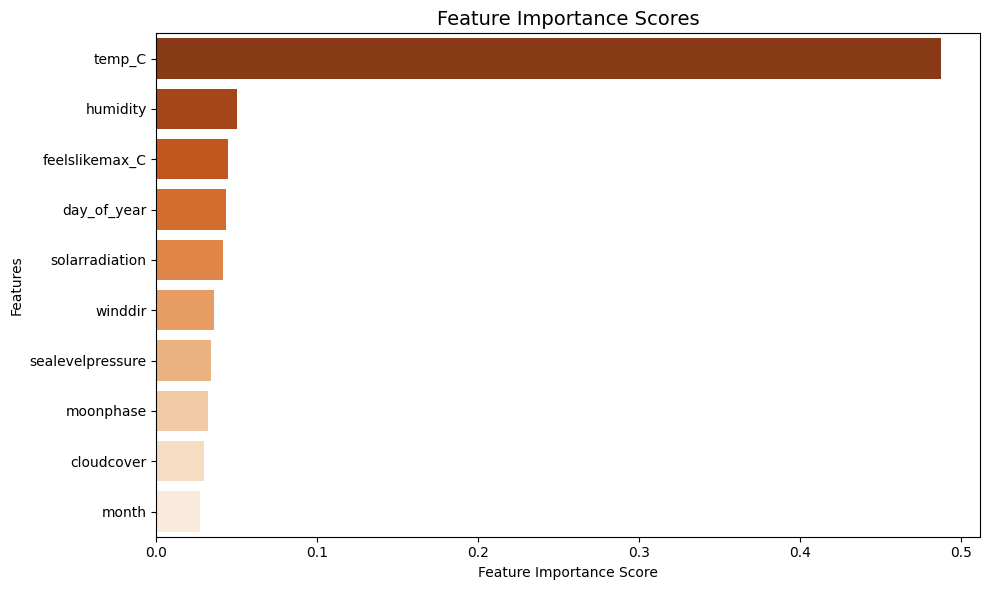

In [74]:
# Lấy top-10 đặc trưng 
top_k = 10
s = sorted_feature_importances.head(top_k)

# Vẽ barplot theo chiều ngang
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=s.values, 
    y=s.index,
    hue=s.index,
    palette="Oranges_r", 
    legend=False     
)


ax.set_title("Feature Importance Scores", fontsize=14)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")

plt.tight_layout()
plt.show()

In [75]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(dt_feature_selection_pipeline.named_steps['decision_tree'],
                           threshold="median", prefit=True)

# Dựng lại DF từ đúng transform đã dùng cho selector
X_train_pre = dt_feature_selection_pipeline.named_steps['preprocess'].transform(X_train)
X_val_pre   = dt_feature_selection_pipeline.named_steps['preprocess'].transform(X_val)
X_test_pre  = dt_feature_selection_pipeline.named_steps['preprocess'].transform(X_test)

X_train_sel = selector.transform(X_train_pre)
X_val_sel   = selector.transform(X_val_pre)
X_test_sel  = selector.transform(X_test_pre)

# Lấy mask đặc trưng đã chọn & tên cột sạch tương ứng
support_mask = selector.get_support()
selected_features = feature_names[selector.get_support()]

X_dt_train = pd.DataFrame(X_train_sel, columns=selected_features, index=X_train.index)
X_dt_val   = pd.DataFrame(X_val_sel,   columns=selected_features, index=X_val.index)
X_dt_test  = pd.DataFrame(X_test_sel,  columns=selected_features, index=X_test.index)

print("Number of features before selection:", len(feature_names))
print("Number of features after selection:", X_dt_train.shape[1]) # Some provinces will be removed

Number of features before selection: 40
Number of features after selection: 20


## Save output

In [76]:
dt_train_out = pd.concat(
    [X_dt_train.reset_index(drop=True),
     y_train.rename(TARGET).reset_index(drop=True),
     X_train[['datetime','name']].reset_index(drop=True)],
    axis=1
)
dt_train_out.to_csv(out_dir / 'dt_train.csv', index=False)

dt_val_out = pd.concat(
    [X_dt_val.reset_index(drop=True),
     y_val.rename(TARGET).reset_index(drop=True),
     X_val[['datetime','name']].reset_index(drop=True)],
    axis=1
)
dt_val_out.to_csv(out_dir / 'dt_val.csv', index=False)

dt_test_out = pd.concat(
    [X_dt_test.reset_index(drop=True),
     y_test.rename(TARGET).reset_index(drop=True),
     X_test[['datetime','name']].reset_index(drop=True)],
    axis=1
)
dt_test_out.to_csv(out_dir / 'dt_test.csv', index=False)

# (Khuyên) Lưu danh sách cột đã chọn để tái lập
pd.Series(selected_features, name="dt_selected_features").to_json(out_dir / 'dt_selected_columns.json')

# 6. Leakage-Free Temporal Feature Engineering

In [77]:
def add_new_features_func(df):
    df = df.copy()
    assert np.issubdtype(df['datetime'].dtype, np.dtype('datetime64[ns]').type), \
        "datetime must be datetime64[ns]"
    df = df.sort_values(['name', 'datetime'])
    g = df.groupby('name', group_keys=False)

    # Lags
    for lag in [1, 2, 3, 4]:
        df[f'tempmax_C_lag{lag}'] = g['tempmax_C'].shift(lag)

    for lag in [1, 2]:
        df[f'humidity_lag_{lag}'] = g['humidity'].shift(lag)
        df[f'cloudcover_lag_{lag}'] = g['cloudcover'].shift(lag)

    # Rolling means (quá khứ thuần túy: dùng dữ liệu tới ngày t-1)
    df['tempmax_C_rollmean7'] = g['tempmax_C'].transform(
        lambda s: s.shift(1).rolling(7, min_periods=7).mean()
    )
    df['tempmax_C_rollmean3'] = g['tempmax_C'].transform(
        lambda s: s.shift(1).rolling(3, min_periods=3).mean()
    )
    df['tempmax_C_rollstd7'] = g['tempmax_C'].transform(
        lambda s: s.shift(1).rolling(7, min_periods=7).std()
    )

    # Seasonality (sin/cos)
    month     = df['datetime'].dt.month
    dayofyear = df['datetime'].dt.dayofyear
    df['month_sin'] = np.sin(2 * np.pi * month / 12)
    df['month_cos'] = np.cos(2 * np.pi * month / 12)
    df['doy_sin']   = np.sin(2 * np.pi * dayofyear / 365.25)
    df['doy_cos']   = np.cos(2 * np.pi * dayofyear / 365.25)

    return df

In [78]:
class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, dropna=True):
        self.dropna = dropna

    def fit(self, X, y=None):
        self.columns_ = X.columns
        X_tmp = add_new_features_func(X.copy())
        if self.dropna:
            X_tmp = X_tmp.dropna()
        self.new_features_ = [c for c in X_tmp.columns if c not in self.columns_]
        return self
    
    def transform(self, X):
        X_out = add_new_features_func(X.copy())
        if self.dropna:
            X_out = X_out.dropna()
        return X_out
    
    def get_feature_names_out(self, input_features=None):
        return list(self.columns_) + self.new_features_

# 7. End-to-End Feature Engineering Pipeline

In [79]:
gen_num = [
    'tempmax_C_lag1', 'tempmax_C_lag2', 'tempmax_C_lag3', 'tempmax_C_lag4',
    'tempmax_C_rollmean7', 'tempmax_C_rollmean3', 'tempmax_C_rollstd7',
    'month_sin', 'month_cos', 'doy_sin', 'doy_cos'
]

all_nums = [c for c in num_cols] + gen_num
all_cats = cat_cols

num_proc = Pipeline([
    ('sc', 'passthrough')
])

cat_proc = Pipeline([
    ('ohe', OneHotEncoder(drop=None, handle_unknown='ignore',
                          sparse_output=False, categories=[all_provinces]))
])

fe_preprocess = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pipeline = Pipeline([
    ('add', AddNewFeaturesTransformer(dropna=True)),
    ('fe_preprocess', fe_preprocess)
]).set_output(transform='pandas')

In [80]:
# Transform with Pipeline 
Xt_tr = fe_pipeline.fit_transform(X_train, y_train)
Xt_va = fe_pipeline.transform(X_val)
Xt_te = fe_pipeline.transform(X_test)

# Align y với Xt theo index sau khi dropna
y_tr_aligned = y_train.loc[Xt_tr.index]
y_va_aligned = y_val.loc[Xt_va.index]
y_te_aligned = y_test.loc[Xt_te.index]

# (Sidecar) Lấy datetime & name đúng thứ tự hàng sau FE để lưu ra CSV
sidecar_tr = X_train.loc[Xt_tr.index, ['datetime', 'name']]
sidecar_va = X_val.loc[Xt_va.index, ['datetime', 'name']]
sidecar_te = X_test.loc[Xt_te.index, ['datetime', 'name']]

# Drop cột hằng (nếu có) để tránh cột vô ích/bất định
nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]
Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]

print('Train shape after feature engineering & dropping NaN:', Xt_tr.shape)

Train shape after feature engineering & dropping NaN: (59058, 51)


In [81]:
# Prevent Leakage -> loại 'tempmax_C' nếu còn sót sau FE (do lags/rolling sinh ra dựa trên nó)
Xt_tr = Xt_tr.drop(columns=['tempmax_C'], errors='ignore')
Xt_va = Xt_va.drop(columns=['tempmax_C'], errors='ignore')
Xt_te = Xt_te.drop(columns=['tempmax_C'], errors='ignore')

# 8. Mutual Information Screening

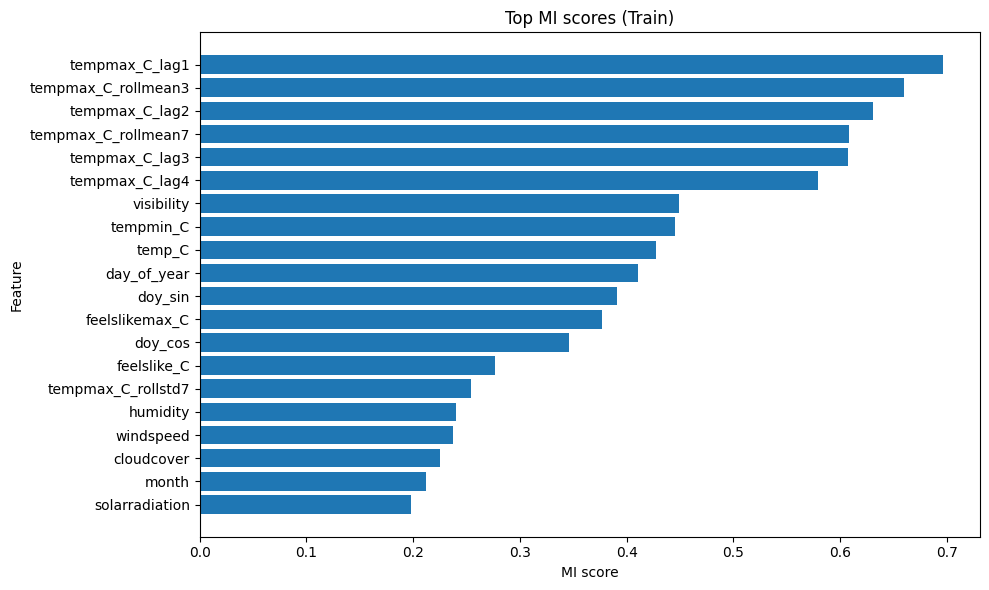

In [82]:
from sklearn.feature_selection import mutual_info_regression

ohe = fe_pipeline.named_steps['fe_preprocess'].named_transformers_['cat'].named_steps['ohe']
cat_names = set(ohe.get_feature_names_out(all_cats)) & set(Xt_tr.columns)
is_discrete = np.array([c in cat_names for c in Xt_tr.columns], dtype=bool)

mi = mutual_info_regression(
    Xt_tr,
    y_tr_aligned.values.ravel(),
    discrete_features=is_discrete,
    random_state=42
)

mi_series = pd.Series(mi, index=Xt_tr.columns).sort_values(ascending=False)

# Vẽ Top-N
N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]

plt.figure(figsize=(10,6))
plt.barh(topN.index, topN.values)
plt.title("Top MI scores (Train)")
plt.xlabel("MI score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('../figures/top_mi_score.png', bbox_inches='tight')
plt.show()


## Save output

In [83]:
K = min(df.columns.drop('target').shape[0], len(mi_series))
topk_cols = list(mi_series.head(K).index)

# Áp top-k lên 3 tập và gắn target
fe_tr = Xt_tr[topk_cols].assign(target=y_tr_aligned.values)
fe_va = Xt_va[topk_cols].assign(target=y_va_aligned.values)
fe_te = Xt_te[topk_cols].assign(target=y_te_aligned.values)

In [84]:
# Train
fe_tr_out = pd.concat(
    [fe_tr.reset_index(drop=True),
     sidecar_tr.reset_index(drop=True)],  # datetime + name (không dùng để fit)
    axis=1
)
fe_tr_out.to_csv(out_dir / 'fe_train.csv', index=False)

# Val
fe_va_out = pd.concat(
    [fe_va.reset_index(drop=True),
     sidecar_va.reset_index(drop=True)],
    axis=1
)
fe_va_out.to_csv(out_dir / 'fe_val.csv', index=False)

# Test
fe_te_out = pd.concat(
    [fe_te.reset_index(drop=True),
     sidecar_te.reset_index(drop=True)],
    axis=1
)
fe_te_out.to_csv(out_dir / 'fe_test.csv', index=False)

# lưu danh sách cột FE & top-k để tái lập/kiểm soát schema
pd.Series(Xt_tr.columns, name="fe_all_columns").to_json(out_dir / 'fe_all_columns.json')
pd.Series(topk_cols, name="fe_topk_features").to_json(out_dir / 'fe_topk_features.json')

# 9. Decision Tree Feature Selection on FE Data

In [85]:
# FE transform trước để align X và y
Xt_tr = fe_pipeline.fit_transform(X_train, y_train)
Xt_va = fe_pipeline.transform(X_val)
Xt_te = fe_pipeline.transform(X_test)

# Align y theo index của Xt_*
y_tr_aligned = y_train.loc[Xt_tr.index]
y_va_aligned = y_val.loc[Xt_va.index]
y_te_aligned = y_test.loc[Xt_te.index]

print("Shape sau FE:", Xt_tr.shape, y_tr_aligned.shape)

Shape sau FE: (59058, 51) (59058,)


In [86]:

# (Sidecar) Lấy datetime & name đúng thứ tự sau FE 
sidecar_tr = X_train.loc[Xt_tr.index, ['datetime', 'name']]
sidecar_va = X_val.loc[Xt_va.index, ['datetime', 'name']]
sidecar_te = X_test.loc[Xt_te.index, ['datetime', 'name']]

# (Khuyến nghị) loại 'tempmax_C' nếu còn (tránh dùng biến hiện tại)
Xt_tr = Xt_tr.drop(columns=['tempmax_C'], errors='ignore')
Xt_va = Xt_va.drop(columns=['tempmax_C'], errors='ignore')
Xt_te = Xt_te.drop(columns=['tempmax_C'], errors='ignore')

In [87]:
# Fit Decision Tree trực tiếp trên dữ liệu sau FE
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(Xt_tr, y_tr_aligned)

# Lấy tên cột sau FE
pipeline_feature_names = fe_pipeline.get_feature_names_out()

# Tính và hiển thị feature importance
feature_importance_series = pd.Series(
    dt_model.feature_importances_,
    index=pipeline_feature_names
).sort_values(ascending=False)

display(feature_importance_series[:10])

tempmax_C_rollmean3    0.417480
temp_C                 0.166643
feelslikemax_C         0.026743
winddir                0.024448
solarradiation         0.024447
cloudcover             0.024291
sealevelpressure       0.023451
tempmax_C_rollmean7    0.021616
doy_sin                0.021196
humidity               0.018571
dtype: float64

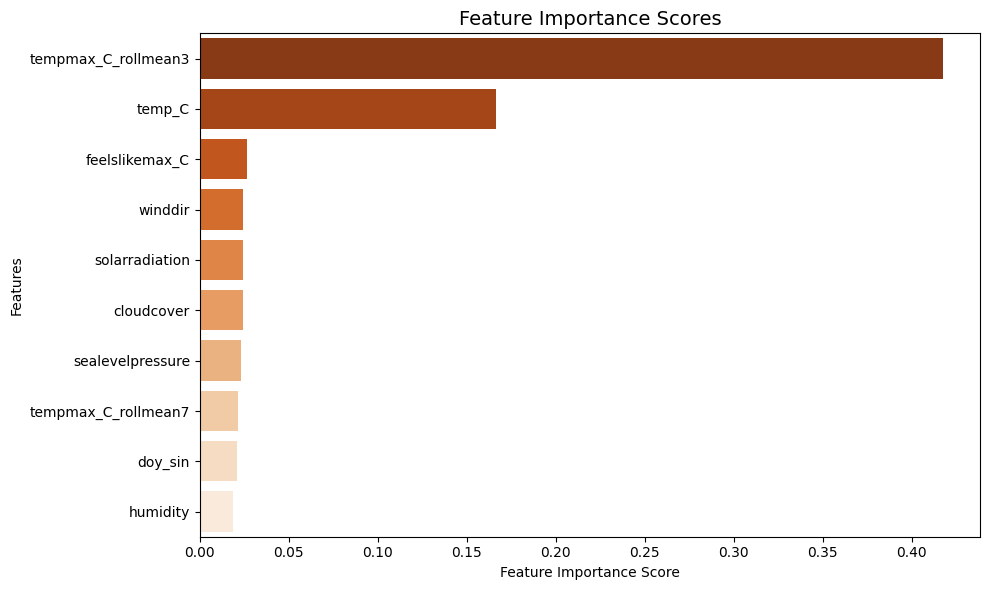

In [88]:
# Lấy top-k đặc trưng (ví dụ 10)
top_k = 10
s = feature_importance_series.head(top_k)

# Vẽ barplot theo chiều ngang
plt.figure(figsize=(10,6))
ax = sns.barplot(x=s.values, y=s.index, hue=s.index, palette='Oranges_r', legend=False)


ax.set_title("Feature Importance Scores", fontsize=14)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")

plt.tight_layout()
plt.show()

In [89]:
# Áp dụng SelectFromModel
selector = SelectFromModel(
    dt_model,               
    threshold="median",     
    prefit=True              
)

# Biến đổi X theo selector
Xt_tr_sel = selector.transform(Xt_tr)
Xt_va_sel = selector.transform(Xt_va)
Xt_te_sel = selector.transform(Xt_te)

# Lấy tên các feature được giữ lại
selected_features = fe_pipeline.get_feature_names_out()[selector.get_support()]

print("Number of Features before selection :", Xt_tr.shape[1])
print("Number of Features after selection    :", Xt_tr_sel.shape[1])

# 6) Tạo DataFrame với các feature đã chọn + target
X_fe_dt_train = pd.DataFrame(Xt_tr_sel, columns=selected_features, index=Xt_tr.index)\
                  #.assign(target=y_tr_aligned.values)

X_fe_dt_val   = pd.DataFrame(Xt_va_sel, columns=selected_features, index=Xt_va.index)\
                  #.assign(target=y_va_aligned.values)

X_fe_dt_test  = pd.DataFrame(Xt_te_sel, columns=selected_features, index=Xt_te.index)\
                  #.assign(target=y_te_aligned.values)

display(X_fe_dt_train.head())

Number of Features before selection : 51
Number of Features after selection    : 26


/Users/jky/Library/CloudStorage/GoogleDrive-lethanhquang094@gmail.com/My Drive/FPT/Semester_3/ADY201m/ADY201m_Proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/jky/Library/CloudStorage/GoogleDrive-lethanhquang094@gmail.com/My Drive/FPT/Semester_3/ADY201m/ADY201m_Proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/jky/Library/CloudStorage/GoogleDrive-lethanhquang094@gmail.com/My Drive/FPT/Semester_3/ADY201m/ADY201m_Proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,dew,humidity,precip,windgust,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,moonphase,...,day_of_week,tempmax_C_lag1,tempmax_C_lag2,tempmax_C_lag3,tempmax_C_lag4,tempmax_C_rollmean7,tempmax_C_rollmean3,tempmax_C_rollstd7,doy_sin,doy_cos
7,71.6,76.1,0.004,16.8,10.3,102.1,1011.8,64.9,202.1,0.60,...,3.0,30.06,31.06,30.06,30.06,29.202857,30.393333,1.676163,0.137185,0.990545
8,69.8,72.9,0.205,12.8,11.4,93.7,1012.4,55.2,224.0,0.63,...,4.0,30.06,30.06,31.06,30.06,29.488571,30.393333,1.618347,0.154204,0.988039
9,71.0,75.3,0.000,12.3,8.1,78.1,1011.7,60.4,209.5,0.66,...,5.0,31.06,30.06,30.06,31.06,30.202857,30.393333,0.690066,0.171177,0.985240
10,72.3,80.0,0.000,13.6,6.9,104.4,1011.5,67.8,222.3,0.70,...,6.0,31.06,31.06,30.06,30.06,30.488571,30.726667,0.534522,0.188099,0.982150
11,71.5,80.0,0.000,15.9,5.8,57.7,1011.7,63.4,203.0,0.73,...,0.0,30.06,31.06,31.06,30.06,30.488571,30.726667,0.534522,0.204966,0.978769


## Save output

In [90]:
# TRAIN
fe_dt_train_out = pd.concat(
    [X_fe_dt_train.reset_index(drop=True),
     y_tr_aligned.rename(TARGET).reset_index(drop=True),
     sidecar_tr.reset_index(drop=True)],  # datetime + name (không dùng để fit)
    axis=1
)
fe_dt_train_out.to_csv(out_dir / 'fe_dt_train.csv', index=False)

# VAL
fe_dt_val_out = pd.concat(
    [X_fe_dt_val.reset_index(drop=True),
     y_va_aligned.rename(TARGET).reset_index(drop=True),
     sidecar_va.reset_index(drop=True)],
    axis=1
)
fe_dt_val_out.to_csv(out_dir / 'fe_dt_val.csv', index=False)

# TEST
fe_dt_test_out = pd.concat(
    [X_fe_dt_test.reset_index(drop=True),
     y_te_aligned.rename(TARGET).reset_index(drop=True),
     sidecar_te.reset_index(drop=True)],
    axis=1
)
fe_dt_test_out.to_csv(out_dir / 'fe_dt_test.csv', index=False)

# schema 
pd.Series(list(selected_features), name="fe_dt_selected_columns").to_json(out_dir / 'fe_dt_selected_columns.json')